<a href="https://colab.research.google.com/github/ccc-frankfurt/Practical_ML_WS19/blob/master/week10/VAE_MLPR_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders
Here, we extend our previous MLP and CNN PyTorch Fashion-MNIST autoencoder example to variational autoencoders and thus generative models. 

Before starting the notebook you should make sure that your runtime uses GPU acceleration. You can find the corresponding option under *runtime* and then *change runtime type*.

In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
print(torch.__version__)

1.3.1


### Dataset class in PyTorch
Our dataset loader essentially remains the same as before. We do not remove the labels to avoid changes to the code, but they are no longer necessary and we will not use them.

In [0]:
import os
import struct
import gzip
import errno
import torch.utils.data
import torchvision.datasets as datasets


class FashionMNIST:
    """
    Fashion MNIST dataset featuring gray-scale 28x28 images of
    fashion items belonging to ten different classes.
    Dataloader adapted from MNIST.
    We do not define __getitem__ and __len__ in this class
    as we are using torch.utils.data.TensorDataSet which
    already implements these methods.

    Parameters:
        args (dict): Dictionary of (command line) arguments.
            Needs to contain batch_size (int) and workers(int).
        is_gpu (bool): True if CUDA is enabled.
            Sets value of pin_memory in DataLoader.

    Attributes:
        trainset (torch.utils.data.TensorDataset): Training set wrapper.
        valset (torch.utils.data.TensorDataset): Validation set wrapper.
        train_loader (torch.utils.data.DataLoader): Training set loader with shuffling.
        val_loader (torch.utils.data.DataLoader): Validation set loader.
    """

    def __init__(self, is_gpu, batch_size, workers):
        self.path = os.path.expanduser('datasets/FashionMNIST')
        self.__download()

        self.trainset, self.valset = self.get_dataset()

        self.train_loader, self.val_loader = self.get_dataset_loader(batch_size, workers, is_gpu)

        self.val_loader.dataset.class_to_idx = {'T-shirt/top': 0,
                                                'Trouser': 1,
                                                'Pullover': 2,
                                                'Dress': 3,
                                                'Coat': 4,
                                                'Sandal': 5,
                                                'Shirt': 6,
                                                'Sneaker': 7,
                                                'Bag': 8,
                                                'Ankle boot': 9}

    def __check_exists(self):
        """
        Checks if dataset has already been downloaded

        Returns:
             bool: True if downloaded dataset has been found
        """

        return os.path.exists(os.path.join(self.path, 'train-images-idx3-ubyte.gz')) and \
               os.path.exists(os.path.join(self.path, 'train-labels-idx1-ubyte.gz')) and \
               os.path.exists(os.path.join(self.path, 't10k-images-idx3-ubyte.gz')) and \
               os.path.exists(os.path.join(self.path, 't10k-labels-idx1-ubyte.gz'))

    def __download(self):
        """
        Downloads the Fashion-MNIST dataset from the web if dataset
        hasn't already been downloaded.
        """

        from six.moves import urllib

        if self.__check_exists():
            return

        print("Downloading FashionMNIST dataset")
        urls = [
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/train-images-idx3-ubyte.gz',
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/train-labels-idx1-ubyte.gz',
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/t10k-images-idx3-ubyte.gz',
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/t10k-labels-idx1-ubyte.gz',
        ]

        # download files
        try:
            os.makedirs(self.path)
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.path, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())

        print('Done!')

    def __get_fashion_mnist(self, path, kind='train'):
        """
        Load Fashion-MNIST data

        Parameters:
            path (str): Base directory path containing .gz files for
                the Fashion-MNIST dataset
            kind (str): Accepted types are 'train' and 't10k' for
                training and validation set stored in .gz files

        Returns:
            numpy.array: images, labels
        """

        labels_path = os.path.join(path,
                                   '%s-labels-idx1-ubyte.gz'
                                   % kind)
        images_path = os.path.join(path,
                                   '%s-images-idx3-ubyte.gz'
                                   % kind)

        with gzip.open(labels_path, 'rb') as lbpath:
            struct.unpack('>II', lbpath.read(8))
            labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

        with gzip.open(images_path, 'rb') as imgpath:
            struct.unpack(">IIII", imgpath.read(16))
            images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 784)

        return images, labels

    def get_dataset(self):
        """
        Loads and wraps training and validation datasets

        Returns:
             torch.utils.data.TensorDataset: trainset, valset
        """

        x_train, y_train = self.__get_fashion_mnist(self.path, kind='train')
        x_val, y_val = self.__get_fashion_mnist(self.path, kind='t10k')

        # This is new with respect to our previous data loader
        # convert to torch tensors in range [0, 1]
        x_train = torch.from_numpy(x_train).float() / 255
        y_train = torch.from_numpy(y_train).long()
        x_val = torch.from_numpy(x_val).float() / 255
        y_val = torch.from_numpy(y_val).long()

        # resize flattened array of images for input to a CNN
        # we use the in-place variant of the resize function here
        x_train.resize_(x_train.size(0), 1, 28, 28)
        x_val.resize_(x_val.size(0), 1, 28, 28)

        # TensorDataset wrapper
        trainset = torch.utils.data.TensorDataset(x_train, y_train)
        valset = torch.utils.data.TensorDataset(x_val, y_val)

        return trainset, valset

    def get_dataset_loader(self, batch_size, workers, is_gpu):
        """
        Defines the dataset loader for wrapped dataset

        Parameters:
            batch_size (int): Defines the batch size in data loader
            workers (int): Number of parallel threads to be used by data loader
            is_gpu (bool): True if CUDA is enabled so pin_memory is set to True

        Returns:
             torch.utils.data.TensorDataset: trainset, valset
        """

        # multi-threaded data loaders
        train_loader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size, shuffle=True,
                                                   num_workers=workers, pin_memory=is_gpu, sampler=None)
        test_loader = torch.utils.data.DataLoader(self.valset, batch_size=batch_size, shuffle=True,
                                                  num_workers=workers, pin_memory=is_gpu, sampler=None)

        return train_loader, test_loader


Let's load the data and set the device to use. 

In [3]:
# set a boolean flag that indicates whether a cuda capable GPU is available 
# we will need this for transferring our tensors to the device and 
# for persistent memory in the data loader
is_gpu = torch.cuda.is_available()
print("GPU is available:", is_gpu)
print("If you are receiving False, try setting your runtime to GPU")

# set the device to cuda if a GPU is available
device = torch.device("cuda" if is_gpu else "cpu")

# in contrast to our MLP from scratch notebook, we need to set the batch size already now
# this is because our data loader now requires it.
batch_size = 128
# we also set the amount of workers, i.e. parallel threads to use in our data loader
workers = 4

# We can now instantiate our dataset class 
dataset = FashionMNIST(is_gpu, batch_size, workers)

GPU is available: True
If you are receiving False, try setting your runtime to GPU


# Variational Autoencoder
We have seen how we can encode data into a latent vector and decode back to the original image for training with reconstruction loss.  

In the lecture we have encountered another Bayesian variant, called the variational autoencoder that provides a different perspective with a powerful generative model: https://arxiv.org/abs/1312.6114 . 
We will now minimize the variational lower bound on the evidence (ELBO). To approximate the true posterior to the generative model p(x, z) we will use our neural network encoder to calculate q(x|z) (the approximate posterior). This is sometimes also referred to as the recognition model.

The probabilistic decoder p(x|z) in turn computes the probability density of an input x under the generative model given a sample z from the approximate posterior q(z|x). Like in the autoencoder the parameters of encoder and decoder are optimized jointly. 

We can conduct this optimization using the reparameterization trick, where we express the random variable z through a deterministic variable as seen in the lecture.

In practical terms, in contrast to the regular autoencoder, we thus now optimize for both a reconstruction loss and KL divergence between our prior and approximate posterior. 

Following the lecture, we will use a Gaussian prior and implement the corresponding reparameterization.

A good in-depth introduction to variational auto-encoders for further reading can be found here: https://arxiv.org/abs/1906.02691

## Building our CNN model
Last week we have implemented our PyTorch models with nn.Sequential() containers in order to easily access the model.encoder to train a classifier on top. Prior to that we have seen how we can define our model's layers in the class' constructor and use a forward function to define the execution. This week we will encounter another third variant, where we define multiple custom functions called encode, decode and reparameterize which we can then individually access and define a joint forward function. 

In [0]:
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_CNN, self).__init__()
        
        self.latent_dim = latent_dim 
        
        self.conv1 = nn.Conv2d(1, 64, 5) # input features, output features, kernel size
        self.mp1 = nn.MaxPool2d(2, 2) # kernel size, stride
        
        self.conv2 = nn.Conv2d(64, 128, 5) # input features, output features, kernel size
        self.mp2 = nn.MaxPool2d(2, 2) # kernel size, stride
        
        # 4x4 is the remaining spatial resolution here
        self.latent_mu = nn.Linear(128*4*4, latent_dim) 
        self.latent_sigma = nn.Linear(128*4*4, latent_dim)
        
        # decoder layers
        self.latent_decode = nn.Linear(latent_dim, 128*4*4)
        self.tconv2 = nn.ConvTranspose2d(128, 64, 5)
        self.tconv1 = nn.ConvTranspose2d(64, 1, 5)
        
        self.Upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
    def encode(self, x):
        # Conv + ReLU + max pooling for two layers
        x = self.mp1(F.relu(self.conv1(x)))
        x = self.mp2(F.relu(self.conv2(x)))
        # The view flattens the output to a vector (the representation needed by the classifier)
        x = x.view(x.size(0), -1)
        mu = self.latent_mu(x)
        sigma = self.latent_sigma(x)
        return mu, sigma
        
    def reparameterize(self, mu, std):
        # reparameterization: z = eps * sigma + mu
        # where eps ~ N(0, 1)
        eps = std.data.new(std.size()).normal_()
        z = eps.mul(std).add(mu)
        return z
    
    def decode(self, z):
        x = self.latent_decode(z)
        x = x.view(-1, 128, 4, 4)
        x = self.Upsample(x)
        x = self.Upsample(F.relu(self.tconv2(x)))
        x = self.tconv1(x)
        return x
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        z = self.reparameterize(mu, sigma)
        x = self.decode(z)
        return x, mu, sigma

#### We will now also have to define our loss function
In addition to the reconstruction loss, we need to implement the KL divergence between the approximate posterior, thus our latent mu and sigma and our unit Gaussian prior. 

We again add a convenience class to log our losses

In [0]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

and the extended loss function

In [0]:
def VAE_loss_function(output, target, mu, std):
    recon_loss_func = nn.BCEWithLogitsLoss(reduction='sum')

    # compute reconstruction loss - normalize by batch size
    recon_loss = recon_loss_func(output, target) / output.size(0)
    
    # numerical value for stability of log computation
    eps = 1e-8
    # compute Kullback Leibler Divergence - normalize by batch size
    kld = -0.5 * torch.sum(1 + torch.log(eps + std ** 2) - (mu ** 2) - (std ** 2)) / output.size(0)
    
    return recon_loss, kld

We will also need to modify our training and validation functions to include the modified loss and let the model return our latent mu and sigma vectors

In [0]:
def train(train_loader, model, criterion, optimizer, device):
    """
    Trains/updates the model for one epoch on the training dataset.

    Parameters:
        train_loader (torch.utils.data.DataLoader): The trainset dataloader
        model (torch.nn.module): Model to be trained
        criterion (torch.nn.criterion): Loss function
        optimizer (torch.optim.optimizer): optimizer instance like SGD or Adam
        device (string): cuda or cpu
    """

    # create an instance of the average meter to track losses
    losses = AverageMeter()
    recon_losses = AverageMeter()
    kl_losses = AverageMeter()

    # switch to train mode
    model.train()

    # iterate through the dataset loader
    # we can now discard the labels returned by our old data loader as we no longer need them
    for i, (inp, _) in enumerate(train_loader):
        # transfer inputs and targets to the GPU (if it is available)
        inp = inp.to(device)
        target = inp
        
        # you can make your autoencoder a denoising autoencoder by 
        # adding noise to the input, but not to the target!
        # To test the denoising autoencoder, uncomment the line below, 
        # where we add a small Gaussian noise to the original images
        #inp = inp + torch.randn(inp.size()).to(device) * 0.1
        
        # compute output, i.e. the model forward. 
        # In contrast to our autoencoder this now also returns the latent mu
        # and sigma that we need to calculate the KL divergence
        output, latent_mu, latent_sigma = model(inp)
        
        # calculate the loss
        recon_loss, kl_loss = criterion(output, target, latent_mu, latent_sigma)
        loss = recon_loss + kl_loss

        # record loss
        losses.update(loss.item(), inp.size(0))
        recon_losses.update(recon_loss.item(), inp.size(0))
        kl_losses.update(kl_loss.item(), inp.size(0))

        # compute gradient and do the SGD step
        # we reset the optimizer with zero_grad to "flush" former gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print the loss every 100 mini-batches
        if i % 100 == 0:
            print('Loss {loss.val:.4f} ({loss.avg:.4f}) \t'
                  'Reconstruction {recon.val:.4f} ({recon.avg:.4f}) \t'
                  'KLD {kld.val:.4f} ({kld.avg:.4f})'
                  .format(loss=losses, recon=recon_losses, kld=kl_losses))

In [0]:
def validate(val_loader, model, criterion, device):
    """
    Trains/updates the model for one epoch on the training dataset.

    Parameters:
        val_loader (torch.utils.data.DataLoader): The valset dataloader
        model (torch.nn.module): Model to be trained
        criterion (torch.nn.criterion): Loss function
        device (string): cuda or cpu
    """

    # create an instance of the average meter to track losses
    losses = AverageMeter()
    recon_losses = AverageMeter()
    kl_losses = AverageMeter()

    # switch to train mode
    model.eval()

    # iterate through the dataset loader
    # we can now discard the labels returned by our old data loader as we no longer need them
    for i, (inp, _) in enumerate(val_loader):
        # transfer inputs and targets to the GPU (if it is available)
        inp = inp.to(device)
        target = inp
        
        # compute output, i.e. the model forward. 
        # In contrast to our autoencoder this now also returns the latent mu
        # and sigma that we need to calculate the KL divergence
        output, latent_mu, latent_sigma = model(inp)
        
        # calculate the loss
        recon_loss, kl_loss = criterion(output, target, latent_mu, latent_sigma)
        loss = recon_loss + kl_loss

        # record loss
        losses.update(loss.item(), inp.size(0))
        recon_losses.update(recon_loss.item(), inp.size(0))
        kl_losses.update(kl_loss.item(), inp.size(0))
        
        # print the loss every 100 mini-batches
        if i % 100 == 0:
            print('Loss {loss.val:.4f} ({loss.avg:.4f}) \t'
                  'Reconstruction {recon.val:.4f} ({recon.avg:.4f}) \t'
                  'KLD {kld.val:.4f} ({kld.avg:.4f})'
                  .format(loss=losses, recon=recon_losses, kld=kl_losses))

In addition to training and validation, we can now also write a generation function. Once the model is training and minimizing the divergence between our approximate posterior distribution and our Gaussian prior, we can start sampling from the prior and directly generate images from the corresponding latent vector z. 

In [0]:
def generate(model, device, num_images=100):
    with torch.no_grad():
        # sample from the Gaussian prior p(z)
        z = torch.randn(num_images, model.latent_dim).to(device)

        # decode the samples p(x|z)
        # we add a sigmoid function at the end of the decoder to constrain 
        # the generated image to 0-1 range (which is otherwise not guaranteed)
        generated_images = torch.sigmoid(model.decode(z))

        # visualize
        imgs = torchvision.utils.make_grid(generated_images.cpu(),
                                           nrow=int(math.sqrt(generated_images.size(0))),
                                           padding=5)
        npimgs = imgs.numpy()
        # when using matplotlib the color channels are expected to be in the third 
        # instead of the first dimension -> tranpose
        plt.imshow(np.transpose(npimgs, (1,2,0)))
        plt.show()

### Constructing and running the CNN based VAE
Let's create an instance of our VAE model and optimize it. After each epoch we will sample from the prior and generate some example images and took a look at their visual quality.

VAE_CNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (latent_mu): Linear(in_features=2048, out_features=50, bias=True)
  (latent_sigma): Linear(in_features=2048, out_features=50, bias=True)
  (latent_decode): Linear(in_features=50, out_features=2048, bias=True)
  (tconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (tconv1): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1))
  (Upsample): Upsample(scale_factor=2.0, mode=nearest)
)
EPOCH: 1
TRAIN
Loss 669.6785 (669.6785) 	Reconstruction 548.8260 (548.8260) 	KLD 120.8524 (120.8524)
Loss 346.7425 (423.8882) 	Reconstruction 322.1876 (397.6013) 	KLD 24.5549 (26.2869)
Loss 304.7728 (372.6339) 	Reconstruction 278.4016 (347.0824) 	KLD 26.3712 (25.5515)
Loss 297.8321 (349.258

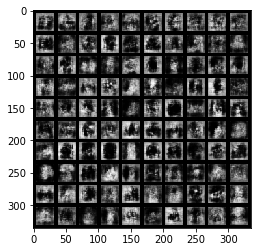

EPOCH: 2
TRAIN
Loss 287.5268 (287.5268) 	Reconstruction 264.4495 (264.4495) 	KLD 23.0773 (23.0773)
Loss 271.5005 (285.1823) 	Reconstruction 249.5931 (262.3188) 	KLD 21.9074 (22.8636)
Loss 280.2108 (283.2264) 	Reconstruction 257.2165 (260.4628) 	KLD 22.9944 (22.7636)
Loss 276.6979 (281.7164) 	Reconstruction 254.8084 (259.2112) 	KLD 21.8895 (22.5052)
Loss 282.2125 (280.2805) 	Reconstruction 261.1343 (258.0143) 	KLD 21.0782 (22.2662)
VALIDATION
Loss 282.5052 (282.5052) 	Reconstruction 261.2579 (261.2579) 	KLD 21.2472 (21.2472)
GENERATION


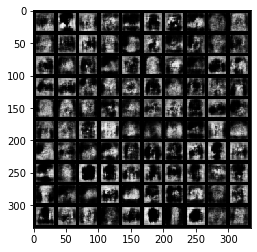

EPOCH: 3
TRAIN
Loss 271.6976 (271.6976) 	Reconstruction 250.2549 (250.2549) 	KLD 21.4426 (21.4426)
Loss 283.1448 (271.8671) 	Reconstruction 262.4555 (251.0579) 	KLD 20.6892 (20.8091)
Loss 269.7874 (270.8621) 	Reconstruction 248.8817 (250.1672) 	KLD 20.9058 (20.6949)
Loss 263.7062 (270.2462) 	Reconstruction 243.4908 (249.6910) 	KLD 20.2154 (20.5552)
Loss 261.0348 (269.6282) 	Reconstruction 240.6577 (249.2193) 	KLD 20.3770 (20.4089)
VALIDATION
Loss 278.8468 (278.8468) 	Reconstruction 259.5386 (259.5386) 	KLD 19.3082 (19.3082)
GENERATION


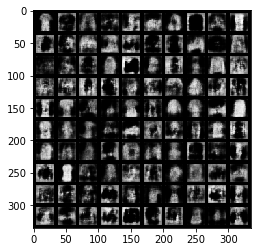

EPOCH: 4
TRAIN
Loss 276.4779 (276.4779) 	Reconstruction 256.8914 (256.8914) 	KLD 19.5865 (19.5865)
Loss 263.5600 (265.0086) 	Reconstruction 243.5648 (245.3142) 	KLD 19.9952 (19.6944)
Loss 264.7535 (264.7082) 	Reconstruction 246.6840 (245.1717) 	KLD 18.0696 (19.5365)
Loss 254.5363 (264.2685) 	Reconstruction 236.5469 (244.7872) 	KLD 17.9894 (19.4813)
Loss 248.3232 (263.6658) 	Reconstruction 229.1789 (244.3086) 	KLD 19.1443 (19.3572)
VALIDATION
Loss 266.1126 (266.1126) 	Reconstruction 247.6323 (247.6323) 	KLD 18.4803 (18.4803)
GENERATION


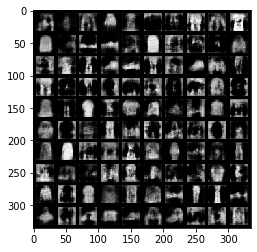

EPOCH: 5
TRAIN
Loss 257.9216 (257.9216) 	Reconstruction 239.7099 (239.7099) 	KLD 18.2117 (18.2117)
Loss 247.9596 (260.6134) 	Reconstruction 228.9116 (241.8540) 	KLD 19.0480 (18.7594)
Loss 263.0369 (260.3709) 	Reconstruction 243.5933 (241.6192) 	KLD 19.4436 (18.7517)
Loss 267.9427 (260.5319) 	Reconstruction 248.8813 (241.7410) 	KLD 19.0614 (18.7909)
Loss 257.1717 (260.2572) 	Reconstruction 238.8325 (241.5147) 	KLD 18.3392 (18.7425)
VALIDATION
Loss 249.8885 (249.8885) 	Reconstruction 231.5273 (231.5273) 	KLD 18.3612 (18.3612)
GENERATION


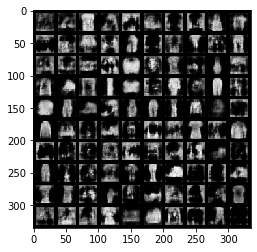

EPOCH: 6
TRAIN
Loss 259.4836 (259.4836) 	Reconstruction 240.9654 (240.9654) 	KLD 18.5182 (18.5182)
Loss 250.8722 (258.3290) 	Reconstruction 232.9101 (239.8669) 	KLD 17.9621 (18.4621)
Loss 261.1537 (257.5995) 	Reconstruction 241.6705 (239.2942) 	KLD 19.4832 (18.3053)
Loss 252.6505 (257.7958) 	Reconstruction 234.1140 (239.4612) 	KLD 18.5365 (18.3346)
Loss 259.8889 (257.3710) 	Reconstruction 241.8715 (239.0819) 	KLD 18.0174 (18.2891)
VALIDATION
Loss 257.7317 (257.7317) 	Reconstruction 239.4808 (239.4808) 	KLD 18.2509 (18.2509)
GENERATION


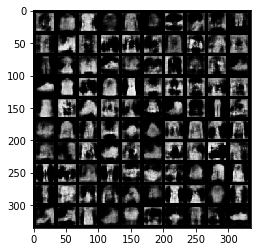

EPOCH: 7
TRAIN
Loss 254.0185 (254.0185) 	Reconstruction 236.6875 (236.6875) 	KLD 17.3310 (17.3310)
Loss 258.9421 (255.0785) 	Reconstruction 241.9067 (237.0887) 	KLD 17.0354 (17.9898)
Loss 250.5609 (255.1300) 	Reconstruction 232.5054 (237.1318) 	KLD 18.0555 (17.9982)
Loss 250.7043 (254.8780) 	Reconstruction 232.6566 (236.9143) 	KLD 18.0477 (17.9637)
Loss 251.7116 (254.4183) 	Reconstruction 233.0894 (236.4764) 	KLD 18.6222 (17.9419)
VALIDATION
Loss 246.8390 (246.8390) 	Reconstruction 228.9998 (228.9998) 	KLD 17.8391 (17.8391)
GENERATION


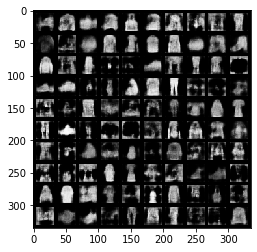

EPOCH: 8
TRAIN
Loss 258.7112 (258.7112) 	Reconstruction 241.3585 (241.3585) 	KLD 17.3526 (17.3526)
Loss 249.1913 (252.5133) 	Reconstruction 231.1519 (234.7172) 	KLD 18.0393 (17.7961)
Loss 260.3137 (252.6346) 	Reconstruction 242.7681 (234.8749) 	KLD 17.5456 (17.7597)
Loss 253.8257 (252.5515) 	Reconstruction 236.4810 (234.8245) 	KLD 17.3447 (17.7269)
Loss 257.7552 (252.2785) 	Reconstruction 239.3753 (234.5639) 	KLD 18.3799 (17.7146)
VALIDATION
Loss 265.4139 (265.4139) 	Reconstruction 248.1282 (248.1282) 	KLD 17.2857 (17.2857)
GENERATION


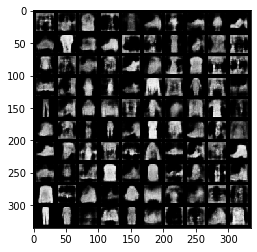

EPOCH: 9
TRAIN
Loss 251.3289 (251.3289) 	Reconstruction 233.7616 (233.7616) 	KLD 17.5673 (17.5673)
Loss 258.8509 (250.9731) 	Reconstruction 240.9527 (233.3647) 	KLD 17.8982 (17.6084)
Loss 258.3223 (251.1812) 	Reconstruction 240.2534 (233.6133) 	KLD 18.0689 (17.5679)
Loss 258.2636 (251.2271) 	Reconstruction 240.9492 (233.6701) 	KLD 17.3144 (17.5571)
Loss 249.4939 (251.0393) 	Reconstruction 231.1008 (233.4928) 	KLD 18.3932 (17.5465)
VALIDATION
Loss 248.9920 (248.9920) 	Reconstruction 231.7515 (231.7515) 	KLD 17.2405 (17.2405)
GENERATION


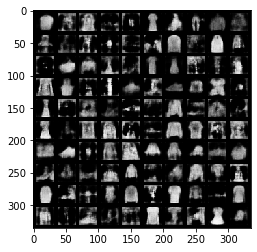

EPOCH: 10
TRAIN
Loss 260.4266 (260.4266) 	Reconstruction 243.2510 (243.2510) 	KLD 17.1756 (17.1756)
Loss 244.2771 (250.6259) 	Reconstruction 227.6471 (233.1201) 	KLD 16.6300 (17.5059)
Loss 256.0024 (250.2010) 	Reconstruction 238.9357 (232.7291) 	KLD 17.0667 (17.4719)
Loss 247.9605 (250.2954) 	Reconstruction 229.8981 (232.7910) 	KLD 18.0624 (17.5044)
Loss 261.3971 (249.9092) 	Reconstruction 243.3975 (232.4280) 	KLD 17.9996 (17.4811)
VALIDATION
Loss 245.9893 (245.9893) 	Reconstruction 229.1673 (229.1673) 	KLD 16.8221 (16.8221)
GENERATION


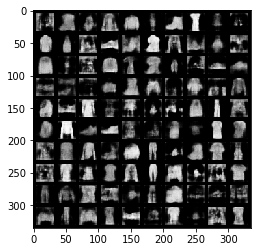

EPOCH: 11
TRAIN
Loss 241.5354 (241.5354) 	Reconstruction 224.0332 (224.0332) 	KLD 17.5022 (17.5022)
Loss 251.9793 (249.0994) 	Reconstruction 234.2267 (231.6877) 	KLD 17.7525 (17.4117)
Loss 246.1354 (249.1758) 	Reconstruction 228.8443 (231.7789) 	KLD 17.2911 (17.3969)
Loss 250.9980 (249.0440) 	Reconstruction 233.2317 (231.6935) 	KLD 17.7663 (17.3505)
Loss 246.8556 (249.2360) 	Reconstruction 229.9039 (231.8955) 	KLD 16.9518 (17.3406)
VALIDATION
Loss 246.8746 (246.8746) 	Reconstruction 229.0618 (229.0618) 	KLD 17.8128 (17.8128)
GENERATION


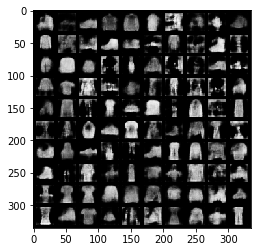

EPOCH: 12
TRAIN
Loss 243.5673 (243.5673) 	Reconstruction 225.9688 (225.9688) 	KLD 17.5985 (17.5985)
Loss 235.1815 (248.8497) 	Reconstruction 217.4698 (231.4950) 	KLD 17.7117 (17.3547)
Loss 232.8870 (249.7365) 	Reconstruction 215.8286 (232.4299) 	KLD 17.0585 (17.3066)
Loss 248.9096 (249.0872) 	Reconstruction 231.3938 (231.8053) 	KLD 17.5157 (17.2819)
Loss 253.2305 (248.9596) 	Reconstruction 235.6178 (231.6842) 	KLD 17.6127 (17.2755)
VALIDATION
Loss 239.6190 (239.6190) 	Reconstruction 223.9469 (223.9469) 	KLD 15.6720 (15.6720)
GENERATION


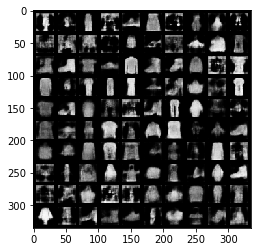

EPOCH: 13
TRAIN
Loss 250.7730 (250.7730) 	Reconstruction 234.4652 (234.4652) 	KLD 16.3078 (16.3078)
Loss 250.0025 (247.1335) 	Reconstruction 232.8294 (229.9881) 	KLD 17.1731 (17.1455)
Loss 247.0571 (247.4861) 	Reconstruction 230.4910 (230.2968) 	KLD 16.5661 (17.1893)
Loss 252.1507 (247.6825) 	Reconstruction 235.2809 (230.4783) 	KLD 16.8698 (17.2042)
Loss 246.6639 (247.7990) 	Reconstruction 229.8915 (230.6159) 	KLD 16.7724 (17.1831)
VALIDATION
Loss 244.5214 (244.5214) 	Reconstruction 227.4954 (227.4954) 	KLD 17.0260 (17.0260)
GENERATION


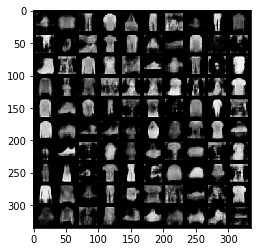

EPOCH: 14
TRAIN
Loss 253.6797 (253.6797) 	Reconstruction 236.5828 (236.5828) 	KLD 17.0969 (17.0969)
Loss 249.6457 (247.5535) 	Reconstruction 232.2580 (230.4201) 	KLD 17.3877 (17.1334)
Loss 255.0084 (248.5327) 	Reconstruction 237.5719 (231.3605) 	KLD 17.4365 (17.1722)
Loss 237.6512 (248.2370) 	Reconstruction 220.3681 (231.0098) 	KLD 17.2831 (17.2272)
Loss 252.5810 (248.2295) 	Reconstruction 235.3651 (230.9925) 	KLD 17.2159 (17.2370)
VALIDATION
Loss 234.3007 (234.3007) 	Reconstruction 217.2283 (217.2283) 	KLD 17.0724 (17.0724)
GENERATION


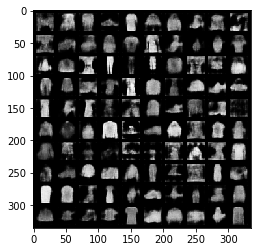

EPOCH: 15
TRAIN
Loss 243.2499 (243.2499) 	Reconstruction 226.1667 (226.1667) 	KLD 17.0833 (17.0833)
Loss 258.3333 (247.7567) 	Reconstruction 241.7048 (230.4993) 	KLD 16.6285 (17.2574)
Loss 255.4222 (247.6293) 	Reconstruction 239.1240 (230.3233) 	KLD 16.2981 (17.3060)
Loss 240.0335 (247.3044) 	Reconstruction 223.1194 (230.0409) 	KLD 16.9141 (17.2635)
Loss 254.4003 (247.1111) 	Reconstruction 237.6585 (229.8790) 	KLD 16.7418 (17.2321)
VALIDATION
Loss 233.7488 (233.7488) 	Reconstruction 216.5537 (216.5537) 	KLD 17.1951 (17.1951)
GENERATION


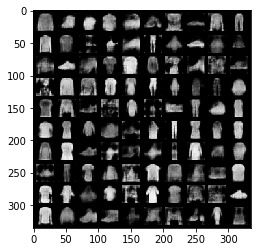

EPOCH: 16
TRAIN
Loss 248.3465 (248.3465) 	Reconstruction 231.0350 (231.0350) 	KLD 17.3115 (17.3115)
Loss 249.9101 (246.4774) 	Reconstruction 232.6357 (229.4028) 	KLD 17.2744 (17.0746)
Loss 240.8026 (246.1649) 	Reconstruction 223.3733 (229.0964) 	KLD 17.4293 (17.0685)
Loss 246.1146 (246.6040) 	Reconstruction 228.9281 (229.5498) 	KLD 17.1864 (17.0543)
Loss 259.4389 (246.4614) 	Reconstruction 241.0707 (229.4146) 	KLD 18.3682 (17.0468)
VALIDATION
Loss 237.9760 (237.9760) 	Reconstruction 221.3247 (221.3247) 	KLD 16.6513 (16.6513)
GENERATION


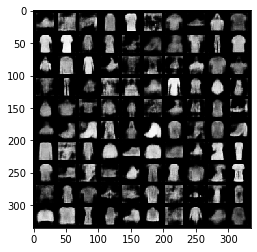

EPOCH: 17
TRAIN
Loss 245.2876 (245.2876) 	Reconstruction 228.4419 (228.4419) 	KLD 16.8457 (16.8457)
Loss 234.6347 (246.5863) 	Reconstruction 217.8336 (229.6157) 	KLD 16.8011 (16.9706)
Loss 246.6426 (246.3593) 	Reconstruction 228.0682 (229.3130) 	KLD 18.5744 (17.0463)
Loss 243.3443 (245.9863) 	Reconstruction 226.5035 (228.9869) 	KLD 16.8408 (16.9994)
Loss 241.5956 (246.0755) 	Reconstruction 225.1707 (229.0632) 	KLD 16.4249 (17.0124)
VALIDATION
Loss 246.5844 (246.5844) 	Reconstruction 229.4861 (229.4861) 	KLD 17.0983 (17.0983)
GENERATION


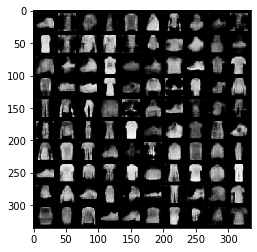

EPOCH: 18
TRAIN
Loss 256.3201 (256.3201) 	Reconstruction 238.8455 (238.8455) 	KLD 17.4746 (17.4746)
Loss 238.0999 (244.3943) 	Reconstruction 221.2356 (227.6172) 	KLD 16.8642 (16.7771)
Loss 252.6589 (245.4232) 	Reconstruction 235.8785 (228.5702) 	KLD 16.7804 (16.8529)
Loss 246.2999 (245.7405) 	Reconstruction 229.6577 (228.8526) 	KLD 16.6422 (16.8879)
Loss 249.4195 (245.6003) 	Reconstruction 231.3662 (228.6905) 	KLD 18.0534 (16.9097)
VALIDATION
Loss 244.0632 (244.0632) 	Reconstruction 226.7308 (226.7308) 	KLD 17.3324 (17.3324)
GENERATION


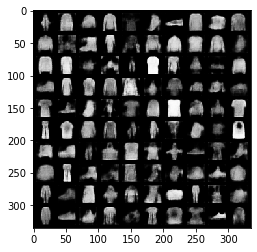

EPOCH: 19
TRAIN
Loss 239.8702 (239.8702) 	Reconstruction 222.5509 (222.5509) 	KLD 17.3192 (17.3192)
Loss 245.8009 (245.4852) 	Reconstruction 229.4706 (228.5380) 	KLD 16.3304 (16.9472)
Loss 251.3302 (245.7249) 	Reconstruction 233.6313 (228.7621) 	KLD 17.6990 (16.9627)
Loss 246.3032 (245.3814) 	Reconstruction 229.0891 (228.4724) 	KLD 17.2141 (16.9091)
Loss 253.6738 (245.2331) 	Reconstruction 235.1845 (228.3362) 	KLD 18.4893 (16.8969)
VALIDATION
Loss 253.1427 (253.1427) 	Reconstruction 236.1061 (236.1061) 	KLD 17.0366 (17.0366)
GENERATION


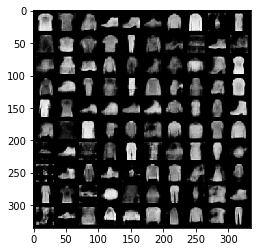

EPOCH: 20
TRAIN
Loss 239.9456 (239.9456) 	Reconstruction 222.3126 (222.3126) 	KLD 17.6329 (17.6329)
Loss 238.8119 (244.2737) 	Reconstruction 221.2860 (227.4429) 	KLD 17.5259 (16.8309)
Loss 241.6866 (244.7910) 	Reconstruction 224.9156 (228.0158) 	KLD 16.7711 (16.7753)
Loss 236.2533 (244.7229) 	Reconstruction 219.8723 (227.9437) 	KLD 16.3811 (16.7792)
Loss 246.7871 (244.7617) 	Reconstruction 229.6939 (227.9781) 	KLD 17.0932 (16.7836)
VALIDATION
Loss 247.3267 (247.3267) 	Reconstruction 230.4363 (230.4363) 	KLD 16.8904 (16.8904)
GENERATION


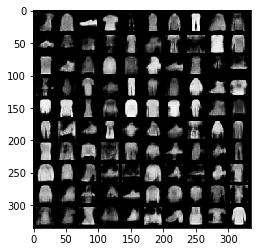

In [10]:
# create VAE model instance
latent_dim = 50 # like in the autoencoder, this is a hyper-parameter
# a good starting point for the above model is a latent dimension of 50.
model = VAE_CNN(latent_dim).to(device)
print(model)

# again, define loss function and optimizer. This time using our custom loss.
criterion = VAE_loss_function

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# optimize
total_epochs = 20
for epoch in range(total_epochs):
    print("EPOCH:", epoch + 1)
    print("TRAIN")
    train(dataset.train_loader, model, criterion, optimizer, device)
    print("VALIDATION")
    validate(dataset.val_loader, model, criterion, device)
    print("GENERATION")
    generate(model, device, num_images=100)

We can see that initially the samples do not look like the data from our training distribution, but after some epochs of optimizing the generative model we are able to generate images by decoding the samples from our Gaussian prior. 

# Additional exercises

1. Use a 2 dimensional latent space and visualize the latent space of the trained model as well as traverse deterministic z values during generation to see how the model interpolates between different concepts. 
2. Try out last week's pre-training and semi-supervised classification scenarios. Note that as you receive samples z ~ q(z|x) that you now classify p(y|z), you can use multiple samples to get uncertainty estimates! Try to see how this impacts your classification scenario. 